In [1]:
from sklearn.cluster import KMeans
import numpy as np
import os
import cv2 as cv
import matplotlib.pyplot as plt
import import_ipynb
from cluster_images_kmeans import cluster
from crop_clustering import cluster_crop
import sys
import skimage
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color
from tqdm import tqdm_notebook
from sklearn.decomposition import PCA

importing Jupyter notebook from cluster_images_kmeans.ipynb
importing Jupyter notebook from crop_clustering.ipynb


In [2]:
def crop(image,k):
    copy = image.copy()
    
    ##perform kmeans clustering with k=3
    segmented_image,labels = cluster_crop(image,3)
    
    ##create canny edges
    edges = cv.Canny(segmented_image,110,190)

    ##find contours
    contours, hierarchy = cv.findContours(edges, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

    ##create bounding rectangle for contours and find rect with max area
    max_area = 0
    m_x = 0
    m_y = 0
    m_w = 0
    m_h = 0
    for cont in contours:
        (x,y,w,h) = cv.boundingRect(cont)
        area = w*h
        if area > max_area:
            max_area = area
            m_x = x
            m_y = y
            m_w = w
            m_h = h
    ##make the rect slightly bigger
    k = 3 ##no of pixels which has to be added to the sides
    
    m_x = max(m_x - k,0)
    m_y = max(m_y - k,0)
    m_h = min(m_h + k,100)
    m_w = min(m_w + k,100)
    ##crop the rectangle!
    
    copy = copy[m_y:m_y+m_h,m_x:m_x+m_w,:]
    if(copy.flatten().size==0):
        return image
    copy = cv.resize(copy,(80,80))
    return copy 

In [3]:
def mask_letter(labels):
    back = labels[0] 
    cluster_size = [0,0,0]
    cluster_size[back] = 600000 ##making the cluster size of background very large so that it is never detected as min
    for i in labels:
        cluster_size[i] = cluster_size[i] + 1
    min_ = cluster_size.index(min(cluster_size))
    return min_

In [4]:
def mask_shape(labels,centers):
    back = labels[0]
    cluster_size = [0,0,0]
    for i in labels:
        cluster_size[i] = cluster_size[i] + 1
    cluster_size[back] = -2**16 ##making the cluster size of background zero so that it is never detected as max
    max_ = cluster_size.index(max(cluster_size))
    return max_

In [5]:
def pipeline(image):


    ## get region of interest
    cropped = crop(image,3)
    
    #Denoising the image
    cropped=cv.fastNlMeansDenoisingColored(cropped,hColor=5,templateWindowSize=3,searchWindowSize=33)
    
    ##perform kmeans clustering on the cropped image with k = 3
    segmented,labels,centers = cluster(cropped,3)
    
    plt.imshow(segmented)
    ##storing the indices of the centroids of the masks
    letter = mask_letter(labels)
    shape=mask_shape(labels,centers)
    return centers[letter],centers[shape],segmented

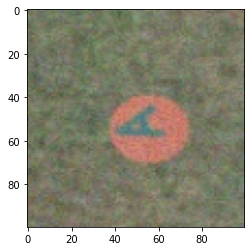

(3, 3)
(array([104, 126, 119], dtype=uint8), array([192, 124, 110], dtype=uint8), array([[[125, 122, 101],
        [125, 122, 101],
        [125, 122, 101],
        ...,
        [125, 122, 101],
        [125, 122, 101],
        [125, 122, 101]],

       [[125, 122, 101],
        [125, 122, 101],
        [125, 122, 101],
        ...,
        [125, 122, 101],
        [125, 122, 101],
        [125, 122, 101]],

       [[125, 122, 101],
        [125, 122, 101],
        [125, 122, 101],
        ...,
        [125, 122, 101],
        [125, 122, 101],
        [125, 122, 101]],

       ...,

       [[125, 122, 101],
        [125, 122, 101],
        [125, 122, 101],
        ...,
        [125, 122, 101],
        [125, 122, 101],
        [125, 122, 101]],

       [[125, 122, 101],
        [125, 122, 101],
        [125, 122, 101],
        ...,
        [125, 122, 101],
        [125, 122, 101],
        [125, 122, 101]],

       [[125, 122, 101],
        [125, 122, 101],
        [125, 122, 101],
     

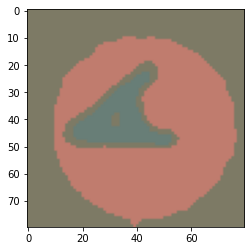

In [6]:
if __name__ == "__main__":
    image=cv.imread('C:/Users/neeti/Projects/Manas/AUVSI/generated_data/letters/A/circle_A_25.jpg')
    plt.imshow(cv.cvtColor(image,cv.COLOR_BGR2RGB))
    plt.show()
    print(pipeline(image))